In [1]:
########## 21 May 2018 - Alec S. Hirschauer ##########
# Today I am going to try to recreate the CMDs and CCDs for NGC 6822 using Python
# (which I had previously made in SuperMongo)
# to simultaneously learn a new plotting language and transfer the plots' utility.
#
# These CMDs and CCDs are from Sewilo et al. (2013) and Whitney et al. (2008),
# and the data come from the catalog of Spitzer sources of Khan et al. (2015)
# matched with IR sources from 2MASS in CasJobs.
#
# Furthermore, I will be making the CMDs and CCDs as number density histograms,
# which will allow us to visualize the data more easily considering that there
# are over 30,000 data points to distinguish in each plot.
#
# And now, I'll be including some new CMDs and CCDs that weren't originally found
# in the Sewilo et al. (2013) and Whitney et al. (2008) papers,
# including specifically K - [?.?] colors.

In [2]:
# First thing needed is to import the relevant Python libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
# This last line is new, and is necessary for the number density histograms.

In [3]:
# Read in my data from a .csv file saved locally.
phot_data = pd.read_csv('CMDparameters27April2018_ahirschauer.csv')
# This is a table of values with ~30,000 rows which contains the photometric data of
# the Khan et al. (2015) catalog matched to 2MASS sources with an "OR" command,
# then downloaded from MAST CasJobs.

In [4]:
# Since the .csv file imported above only has the magnitude values,
# I'll need to set the colors used in the CMDs and CCDs.
# Instead of doing it on a per-figure basis (like before), I've sorted the
# various colors to eliminate duplicates.
#
phot_data['threesixMINUSfourfive'] = phot_data.k36mag.values - phot_data.k45mag.values
phot_data['threesixMINUSfiveeight'] = phot_data.k36mag.values - phot_data.k58mag.values
phot_data['threesixMINUSeightzero'] = phot_data.k36mag.values - phot_data.k80mag.values
phot_data['threesixMINUStwentyfour'] = phot_data.k45mag.values - phot_data.k24mag.values
#
phot_data['fourfiveMINUSfiveeight'] = phot_data.k45mag.values - phot_data.k58mag.values
phot_data['fourfiveMINUSeightzero'] = phot_data.k45mag.values - phot_data.k80mag.values
phot_data['fourfiveMINUStwentyfour'] = phot_data.k45mag.values - phot_data.k24mag.values
#
phot_data['fiveeightMINUSeightzero'] = phot_data.k58mag.values - phot_data.k80mag.values
phot_data['fiveeightMINUStwentyfour'] = phot_data.k58mag.values - phot_data.k24mag.values
#
phot_data['eightzeroMINUStwentyfour'] = phot_data.k80mag.values - phot_data.k24mag.values
#
phot_data['kMINUSthreesix'] = phot_data.kmag.values - phot_data.k36mag.values
phot_data['kMINUSfourfive'] = phot_data.kmag.values - phot_data.k45mag.values

In [28]:
# In addition to the twelve colors specified above,
# here is where I'll define some other colors that might be interesting.
#
phot_data['kMINUSfiveeight'] = phot_data.kmag.values - phot_data.k58mag.values
phot_data['kMINUSeightzero'] = phot_data.kmag.values - phot_data.k80mag.values
phot_data['kMINUStwentyfour'] = phot_data.kmag.values - phot_data.k24mag.values
#
# When I think of more to test, I'll add them here.
#
# Okay, I'm going to make the same colors but using J- & H-band instead.
#
phot_data['jMINUSthreesix'] = phot_data.jmag.values - phot_data.k36mag.values
phot_data['jMINUSfourfive'] = phot_data.jmag.values - phot_data.k45mag.values
phot_data['jMINUSfiveeight'] = phot_data.jmag.values - phot_data.k58mag.values
phot_data['jMINUSeightzero'] = phot_data.jmag.values - phot_data.k80mag.values
phot_data['jMINUStwentyfour'] = phot_data.jmag.values - phot_data.k24mag.values
#
phot_data['hMINUSthreesix'] = phot_data.hmag.values - phot_data.k36mag.values
phot_data['hMINUSfourfive'] = phot_data.hmag.values - phot_data.k45mag.values
phot_data['hMINUSfiveeight'] = phot_data.hmag.values - phot_data.k58mag.values
phot_data['hMINUSeightzero'] = phot_data.hmag.values - phot_data.k80mag.values
phot_data['hMINUStwentyfour'] = phot_data.hmag.values - phot_data.k24mag.values

In [6]:
# In my first iteration of making CMDs, I found a few erroneous color values well in excess
# of the standard plot boundaries, which made the axes ludicrously proportioned.
# While clearly I could simply define the scale of the axes such that these
# outliers are skipped, if I wanted to do any analysis of the dataset as a whole
# it is more useful for me to trim them.
#
# These erroneous color values were all in the vicinity of +/-10,000, which come from
# the fact that 'null' values in the catalog of photometric sources had been set to "-9999"
# and therefore a small value minus -9,999 becomes roughly 10,000,
# or -9,999 minus a small value becomes roughly -10,000.
#
# Rather than set individual cuts for every afflicted column (as I had tried to do earlier),
# I am making a global cut of the whole dataframe so that no value is outside of the range
# of -500.0 to +500.0, which hopefully encompasses everything useful (including RA & Dec).
#
phot_data = phot_data[(phot_data < 500.0) & (phot_data > -500.0)]
#
# The above command trims the 'phot_data' dataframe,
# but later on when I plot and/or analyze the data,
# I'd like to specify that we're dealing with a "filtered" data set,
# so the command below does that.
#
filter_phot_data = phot_data

In [7]:
# Now that the colors are identified and the data is filtered, I will make the plots.
# In total, discarding duplicates, there are 16 different CMDs/CCDs I've used from the
# Sewilo et al. (2013) and Whitney et al. (2008) papers, which from now on I will make
# individually as opposed to in groups according to their original figure number.
#
# As a point of comparison, I will make each of the 16 plots twice; once using points
# to represent the data, and once utilizing a number density histogram method.
#
# UPDATE: Actually, I'll leave all of the 16 previous CMDs/CCDs for the older notebook,
# and only focus on K-band CMDs and whatever new ones I make up here.
# See the file "CMD_10May2018.ipynb" for the original CMDs/CCDs.

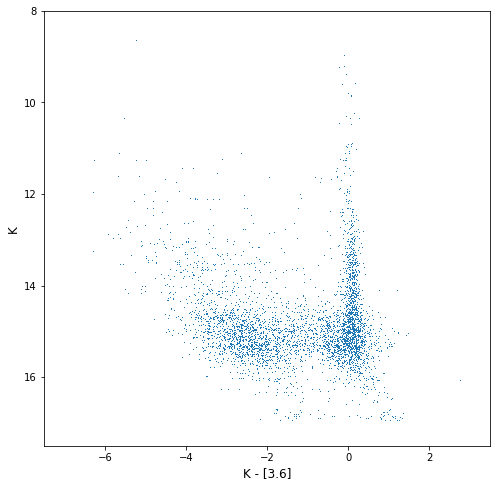

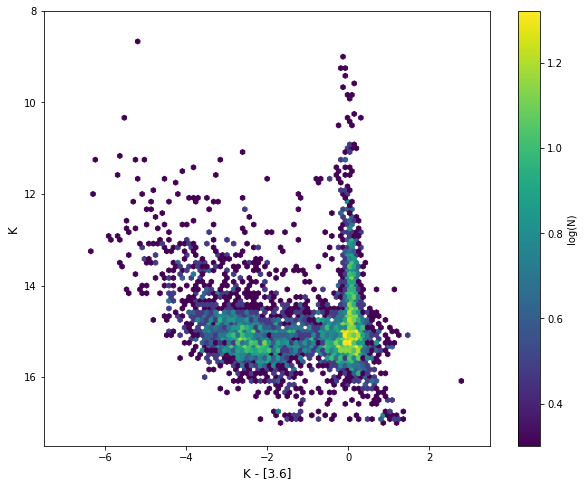

In [8]:
# K vs. K-[3.6]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.kMINUSthreesix,filter_phot_data.kmag,',')
plt.xlim(-7.5, 3.5)
plt.ylim(17.5, 8.0)
plt.xlabel('K - [3.6]', size=12)
plt.ylabel('K', size=12)
#plt.savefig('K_vs_K-[3.6]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-7.5, 3.5)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.kMINUSthreesix, filter_phot_data.kmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-7.5, 3.5, 17.5, 8.0))
ax1.set_xlabel('K - [3.6]', size=12)
ax1.set_ylabel('K', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('K_vs_K-[3.6]_hist.pdf')

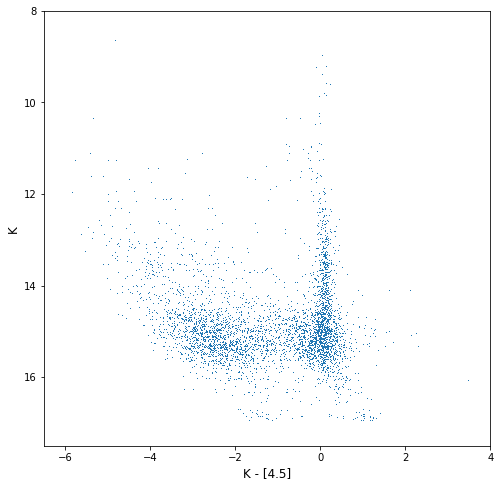

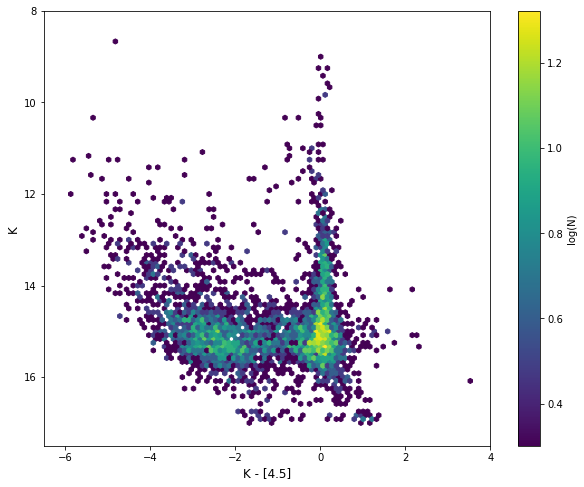

In [9]:
# K vs. K-[4.5]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.kMINUSfourfive,filter_phot_data.kmag,',')
plt.xlim(-6.5, 4.0)
plt.ylim(17.5, 8.0)
plt.xlabel('K - [4.5]', size=12)
plt.ylabel('K', size=12)
#plt.savefig('K_vs_K-[4.5]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-6.5, 4.0)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.kMINUSfourfive, filter_phot_data.kmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-6.5, 4.0, 17.5, 8.0))
ax1.set_xlabel('K - [4.5]', size=12)
ax1.set_ylabel('K', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('K_vs_K-[4.5]_hist.pdf')

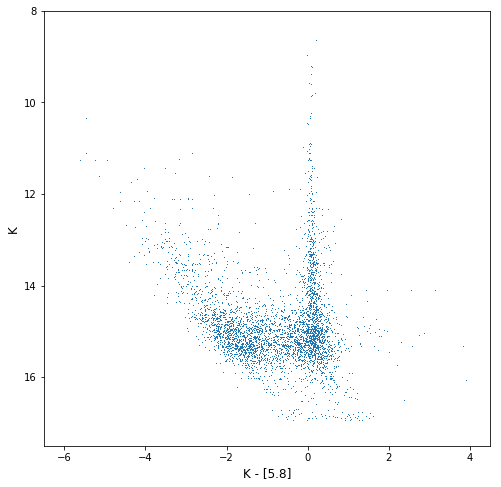

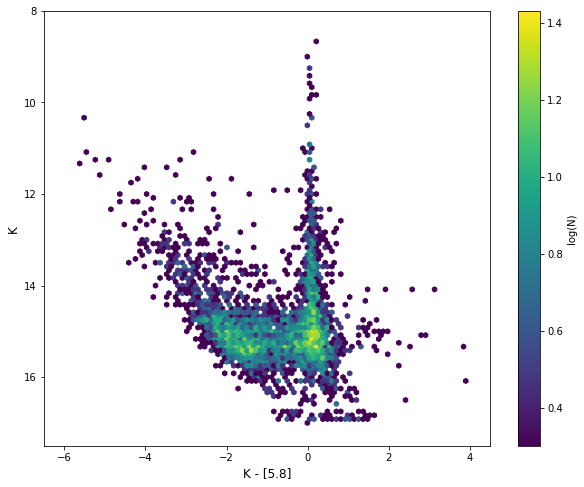

In [14]:
# K vs. K-[5.8]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.kMINUSfiveeight,filter_phot_data.kmag,',')
plt.xlim(-6.5, 4.5)
plt.ylim(17.5, 8.0)
plt.xlabel('K - [5.8]', size=12)
plt.ylabel('K', size=12)
#plt.savefig('K_vs_K-[5.8]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-6.5, 4.5)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.kMINUSfiveeight, filter_phot_data.kmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-6.5, 4.5, 17.5, 8.0))
ax1.set_xlabel('K - [5.8]', size=12)
ax1.set_ylabel('K', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('K_vs_K-[5.8]_hist.pdf')

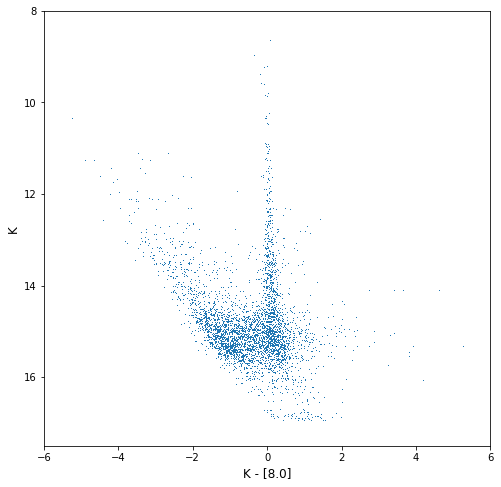

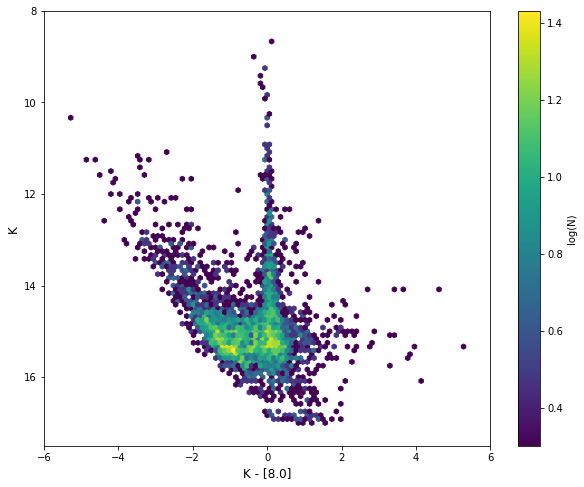

In [17]:
# K vs. K-[8.0]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.kMINUSeightzero,filter_phot_data.kmag,',')
plt.xlim(-6.0, 6.0)
plt.ylim(17.5, 8.0)
plt.xlabel('K - [8.0]', size=12)
plt.ylabel('K', size=12)
#plt.savefig('K_vs_K-[8.0]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-6.0, 6.0)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.kMINUSeightzero, filter_phot_data.kmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-6.0, 6.0, 17.5, 8.0))
ax1.set_xlabel('K - [8.0]', size=12)
ax1.set_ylabel('K', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('K_vs_K-[8.0]_hist.pdf')

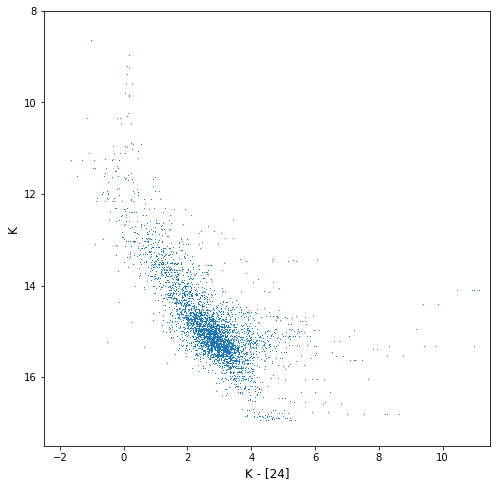

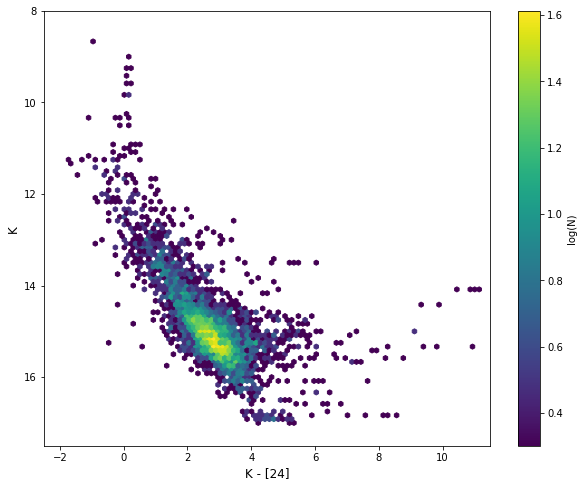

In [24]:
# K vs. K-[24]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.kMINUStwentyfour,filter_phot_data.kmag,',')
plt.xlim(-2.5, 11.5)
plt.ylim(17.5, 8.0)
plt.xlabel('K - [24]', size=12)
plt.ylabel('K', size=12)
#plt.savefig('K_vs_K-[24]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-2.5, 11.5)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.kMINUStwentyfour, filter_phot_data.kmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-2.5, 11.5, 17.5, 8.0))
ax1.set_xlabel('K - [24]', size=12)
ax1.set_ylabel('K', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('K_vs_K-[24]_hist.pdf')

In [25]:
# The new K-band colors here are really interesting!
# As we move from K-[3.6] and K-[4.5] to K-[5.8], K-[8.0], and K-[24],
# the excess of blue points becomes much less pronounced.
#
# This blue excess is a consequence of small values of K-band flux
# and/or large values of the Spitzer fluxes.
#
# Margaret thinks that they are proobably real (and not mistakes),
# especially since their spatial distribution appear coincident with
# NGC 6822 from my analysis using Glueviz.
#
# She thinks we should ask Martha Boyer what she thinks!
#
# In the mean time, I'll make CMDs using the other IR bands (J & H).

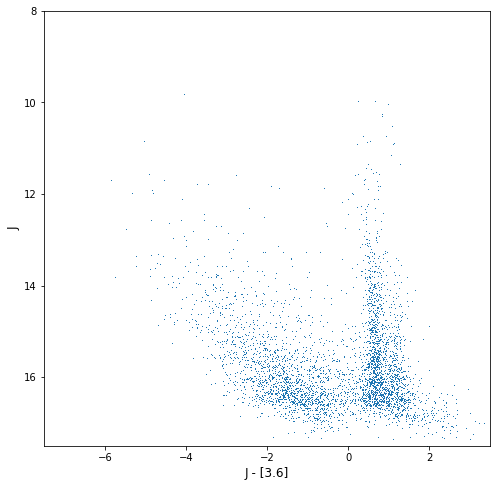

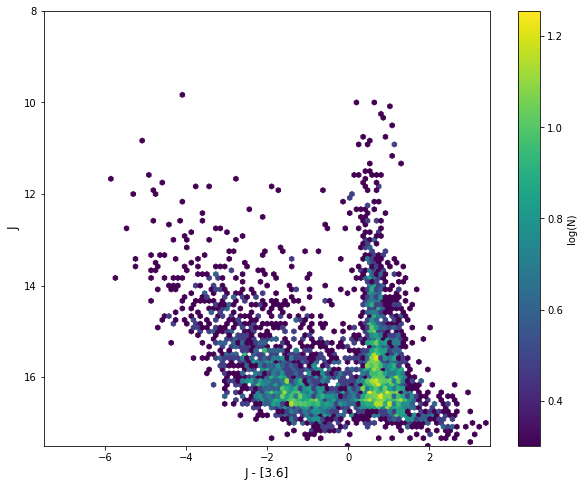

In [29]:
# J vs. J-[3.6]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.jMINUSthreesix,filter_phot_data.jmag,',')
plt.xlim(-7.5, 3.5)
plt.ylim(17.5, 8.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('J', size=12)
#plt.savefig('J_vs_J-[3.6]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-7.5, 3.5)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.jMINUSthreesix, filter_phot_data.jmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-7.5, 3.5, 17.5, 8.0))
ax1.set_xlabel('J - [3.6]', size=12)
ax1.set_ylabel('J', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('J_vs_J-[3.6]_hist.pdf')

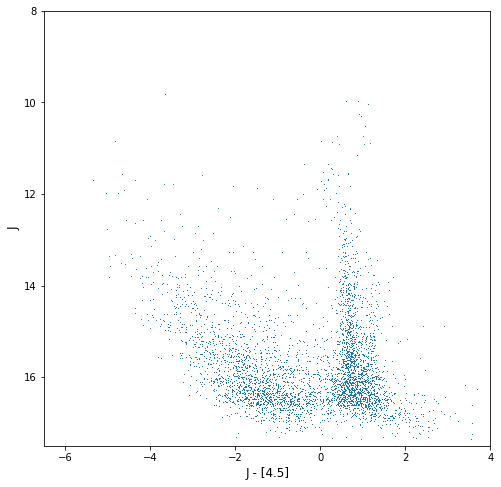

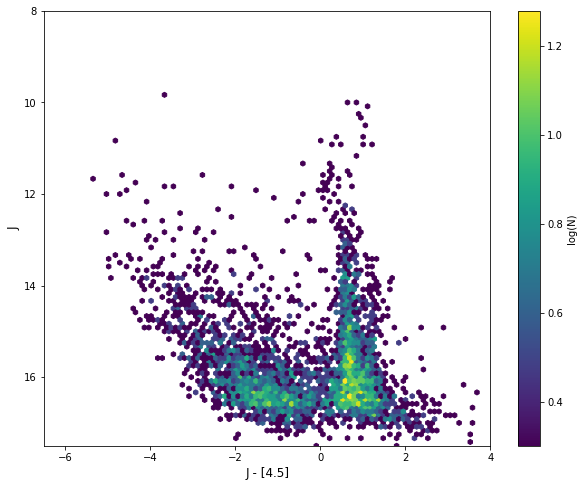

In [31]:
# J vs. J-[4.5]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.jMINUSfourfive,filter_phot_data.jmag,',')
plt.xlim(-6.5, 4.0)
plt.ylim(17.5, 8.0)
plt.xlabel('J - [4.5]', size=12)
plt.ylabel('J', size=12)
#plt.savefig('J_vs_J-[4.5]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-6.5, 4.0)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.jMINUSfourfive, filter_phot_data.jmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-6.5, 4.0, 17.5, 8.0))
ax1.set_xlabel('J - [4.5]', size=12)
ax1.set_ylabel('J', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('J_vs_J-[4.5]_hist.pdf')

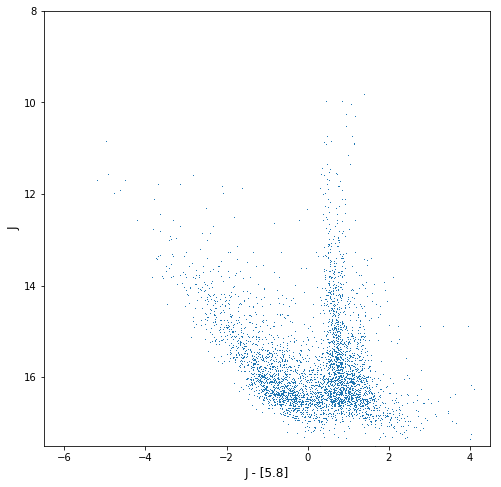

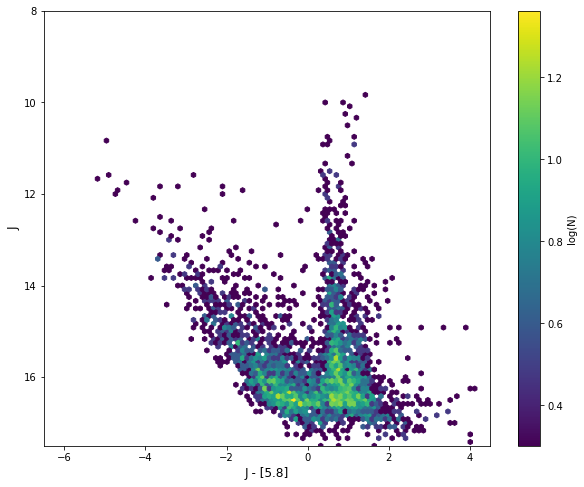

In [32]:
# J vs. J-[5.8]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.jMINUSfiveeight,filter_phot_data.jmag,',')
plt.xlim(-6.5, 4.5)
plt.ylim(17.5, 8.0)
plt.xlabel('J - [5.8]', size=12)
plt.ylabel('J', size=12)
#plt.savefig('J_vs_J-[5.8]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-6.5, 4.5)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.jMINUSfiveeight, filter_phot_data.jmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-6.5, 4.5, 17.5, 8.0))
ax1.set_xlabel('J - [5.8]', size=12)
ax1.set_ylabel('J', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('J_vs_J-[5.8]_hist.pdf')

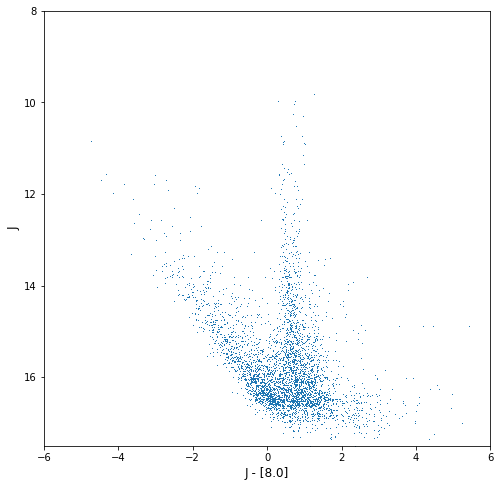

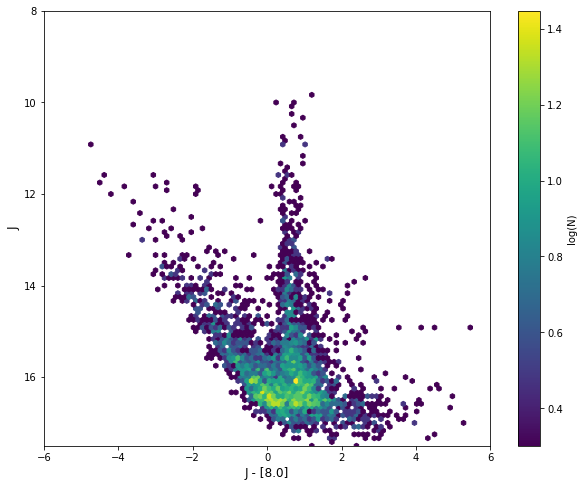

In [33]:
# J vs. J-[8.0]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.jMINUSeightzero,filter_phot_data.jmag,',')
plt.xlim(-6.0, 6.0)
plt.ylim(17.5, 8.0)
plt.xlabel('J - [8.0]', size=12)
plt.ylabel('J', size=12)
#plt.savefig('J_vs_J-[8.0]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-6.0, 6.0)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.jMINUSeightzero, filter_phot_data.jmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-6.0, 6.0, 17.5, 8.0))
ax1.set_xlabel('J - [8.0]', size=12)
ax1.set_ylabel('J', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('J_vs_J-[8.0]_hist.pdf')

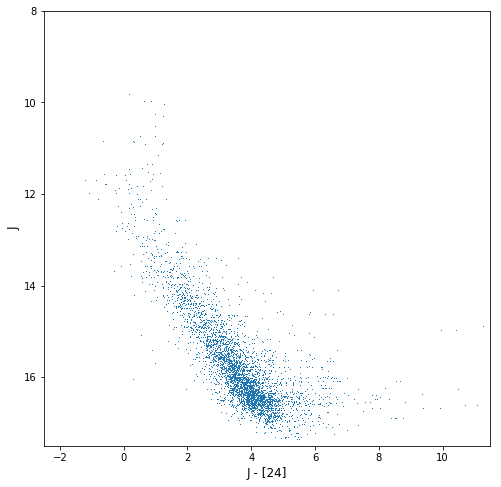

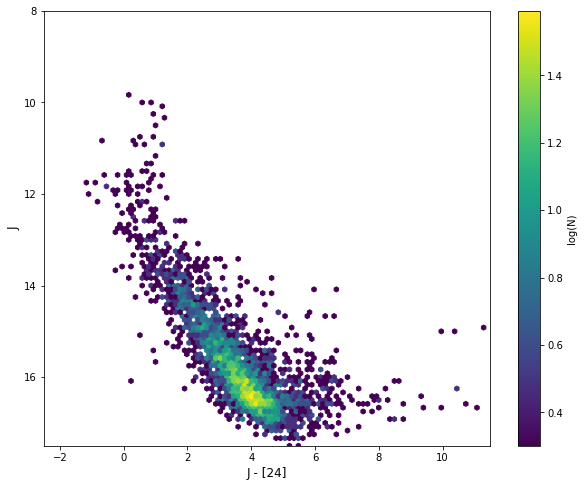

In [34]:
# J vs. J-[24]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.jMINUStwentyfour,filter_phot_data.jmag,',')
plt.xlim(-2.5, 11.5)
plt.ylim(17.5, 8.0)
plt.xlabel('J - [24]', size=12)
plt.ylabel('J', size=12)
#plt.savefig('J_vs_J-[24]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-2.5, 11.5)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.jMINUStwentyfour, filter_phot_data.jmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-2.5, 11.5, 17.5, 8.0))
ax1.set_xlabel('J - [24]', size=12)
ax1.set_ylabel('J', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('J_vs_J-[24]_hist.pdf')

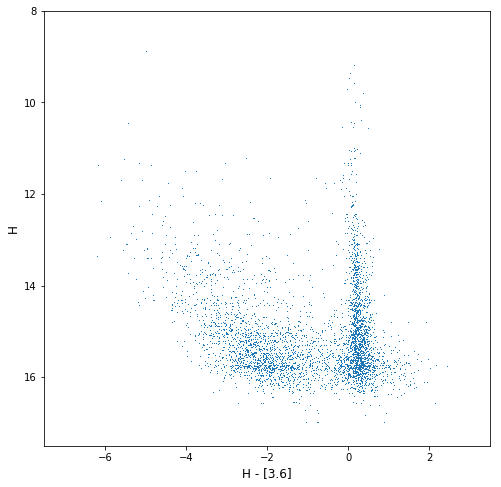

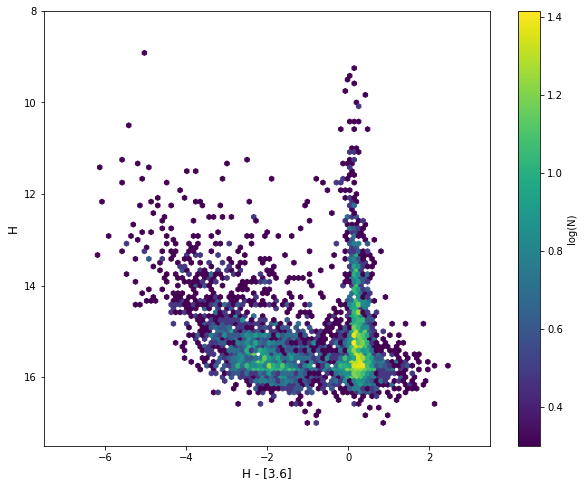

In [35]:
# H vs. H-[3.6]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.hMINUSthreesix,filter_phot_data.hmag,',')
plt.xlim(-7.5, 3.5)
plt.ylim(17.5, 8.0)
plt.xlabel('H - [3.6]', size=12)
plt.ylabel('H', size=12)
#plt.savefig('H_vs_H-[3.6]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-7.5, 3.5)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.hMINUSthreesix, filter_phot_data.hmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-7.5, 3.5, 17.5, 8.0))
ax1.set_xlabel('H - [3.6]', size=12)
ax1.set_ylabel('H', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('H_vs_H-[3.6]_hist.pdf')

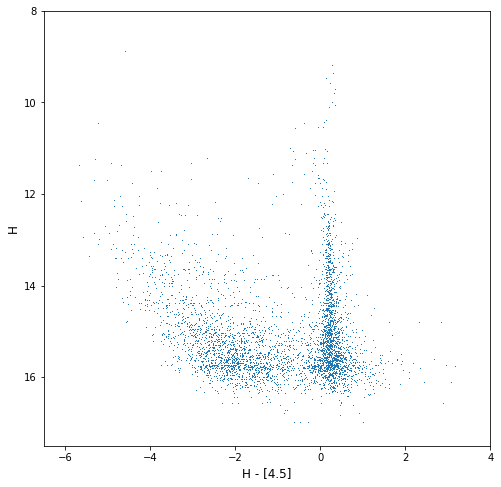

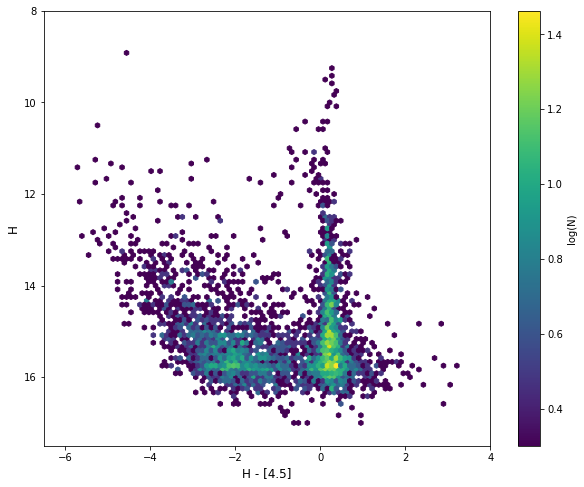

In [36]:
# H vs. H-[4.5]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.hMINUSfourfive,filter_phot_data.hmag,',')
plt.xlim(-6.5, 4.0)
plt.ylim(17.5, 8.0)
plt.xlabel('H - [4.5]', size=12)
plt.ylabel('H', size=12)
#plt.savefig('H_vs_H-[4.5]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-6.5, 4.0)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.hMINUSfourfive, filter_phot_data.hmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-6.5, 4.0, 17.5, 8.0))
ax1.set_xlabel('H - [4.5]', size=12)
ax1.set_ylabel('H', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('H_vs_H-[4.5]_hist.pdf')

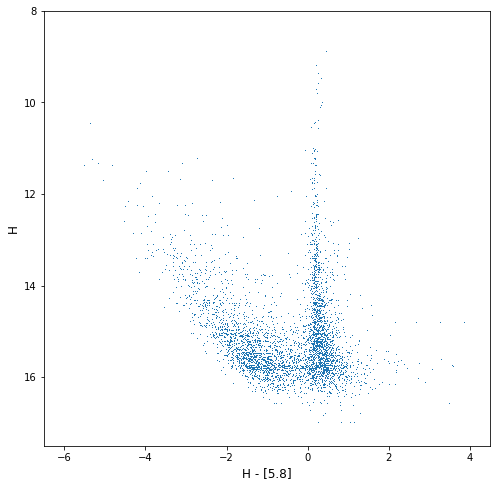

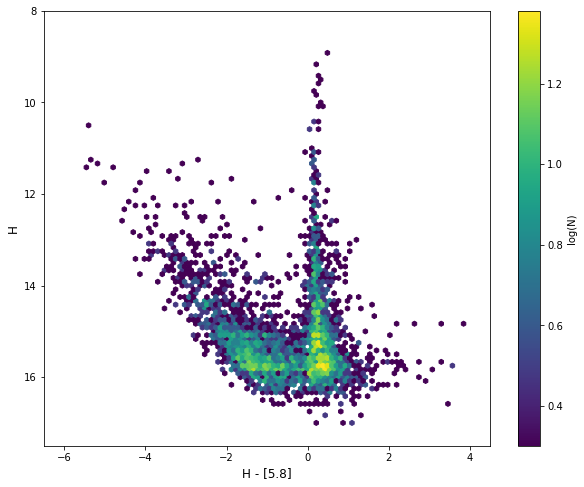

In [37]:
# H vs. H-[5.8]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.hMINUSfiveeight,filter_phot_data.hmag,',')
plt.xlim(-6.5, 4.5)
plt.ylim(17.5, 8.0)
plt.xlabel('H - [5.8]', size=12)
plt.ylabel('H', size=12)
#plt.savefig('H_vs_H-[5.8]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-6.5, 4.5)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.hMINUSfiveeight, filter_phot_data.hmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-6.5, 4.5, 17.5, 8.0))
ax1.set_xlabel('H - [5.8]', size=12)
ax1.set_ylabel('H', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('H_vs_H-[5.8]_hist.pdf')

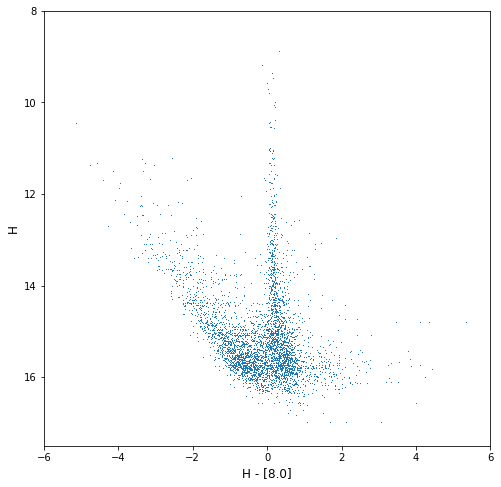

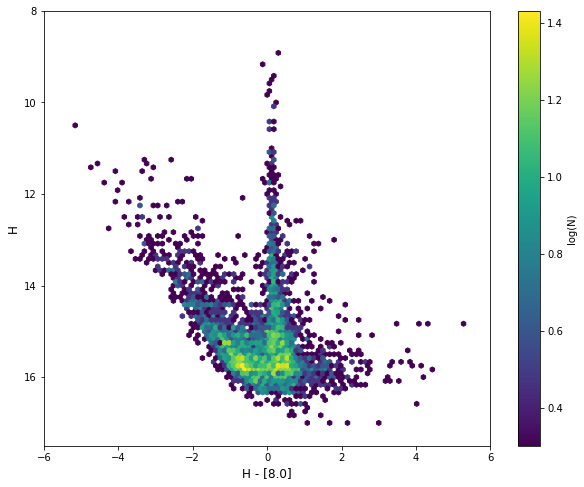

In [38]:
# H vs. H-[8.0]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.hMINUSeightzero,filter_phot_data.hmag,',')
plt.xlim(-6.0, 6.0)
plt.ylim(17.5, 8.0)
plt.xlabel('H - [8.0]', size=12)
plt.ylabel('H', size=12)
#plt.savefig('H_vs_H-[8.0]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-6.0, 6.0)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.hMINUSeightzero, filter_phot_data.hmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-6.0, 6.0, 17.5, 8.0))
ax1.set_xlabel('H - [8.0]', size=12)
ax1.set_ylabel('H', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('H_vs_H-[8.0]_hist.pdf')

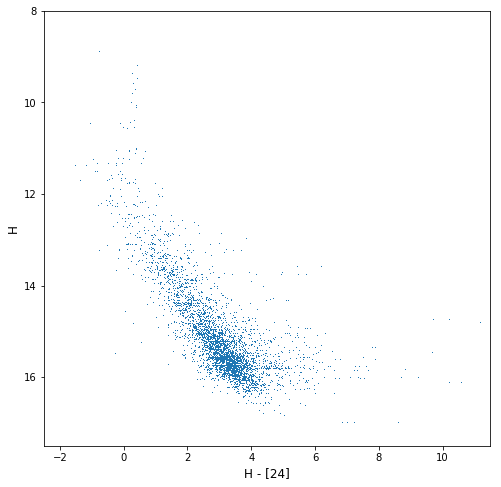

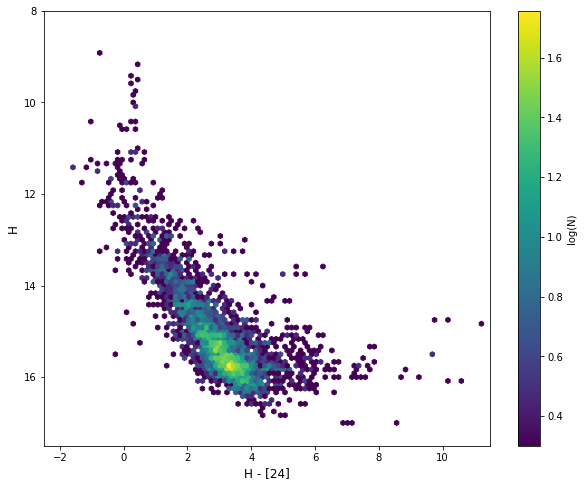

In [39]:
# H vs. H-[24]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.hMINUStwentyfour,filter_phot_data.hmag,',')
plt.xlim(-2.5, 11.5)
plt.ylim(17.5, 8.0)
plt.xlabel('H - [24]', size=12)
plt.ylabel('H', size=12)
#plt.savefig('H_vs_H-[24]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-2.5, 11.5)
plt.ylim(17.5, 8.0)
im1 = ax1.hexbin(filter_phot_data.hMINUStwentyfour, filter_phot_data.hmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-2.5, 11.5, 17.5, 8.0))
ax1.set_xlabel('H - [24]', size=12)
ax1.set_ylabel('H', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('H_vs_H-[24]_hist.pdf')

In [40]:
# Unsuprisingly, the H- and J-band color versions of these CMDs
# share a lot of similarities with the original K-band plots.